# Machine Learning 2 Assignment 2

## Junyoung Jung 

In [46]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torch.optim import SGD
import torch.nn
import numpy as np
import time

### a) Load CIFAR10 dataset as follows:

In [47]:
trainset = datasets.CIFAR10(root='./CIFARdata', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./CIFARdata', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


### b) Visualize at least one image for each class. You may need to look into how dataset is implemented in PyTorch.

In [48]:
labels_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'}

In [49]:
def visualize_image(data):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 4
    check_box = [0 for i in range(10)]
    img, label = 0, 0
    for i in range(1, cols * rows + 1):
        for j in range(len(trainset)):
            img, label = data[j]
            if check_box[label] == 1:
                continue
            else:
                check_box[label] = 1
                break
        figure.add_subplot(rows, cols, i)
        plt.title(labels_dict[label])
        plt.axis("off")
        img = img.permute(1, 2, 0)
        plt.imshow(img.squeeze(), cmap='gray')
    plt.show()


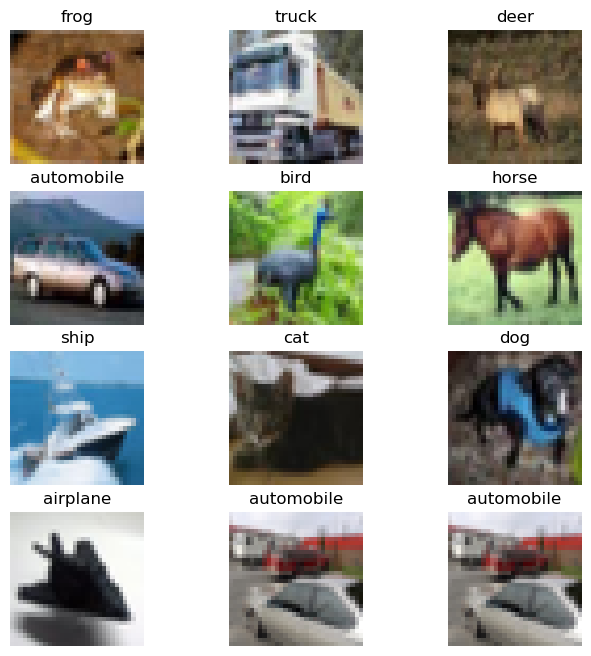

In [9]:
visualize_image(trainset)

### c) Split the trainset into training set and validation set with 90% : 10% ratio. Implement dataloaders for CIFAR10.

In [50]:
total_size = len(trainset)
train_size = int(0.9 * total_size)
val_size = int(0.1 * total_size)

batch_size = 64

train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# data shape[0] = (1, 3, 32, 32)
# label shape[0] = (1)

trainloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, shuffle=True)
testloader = DataLoader(testset, shuffle=False)

anyclass1, anyclass2 = 3, 7

### d) Choose any two classes. Then, make a SVM classifier (implement a loss function yourself. Do not use PyTorch implementations of loss functions.) and its training/validation/evaluation code to perform binary classification between those two classes.


### e) Train for 10 epochs with batch size 64.

In [51]:
class svm(torch.nn.Module):
    def __init__(self):
        super(svm, self).__init__()
        self.fc = torch.nn.Linear(32, 1)

    def forward(self, x):
        fd = self.fc(x)
        return fd

    def hingeloss(self, data, label):
        w, c = self.fc.weight.squeeze(), 0.1
        # for i in range(data_size):
        #     ans = -1
        #     if data[i] is not ans_label1 or ans_label2:
        #         continue
        #     else:
        #         if data[i] is ans_label1:
        #             ans = 1
        #             result = torch.max(zero, 1 - ans * (w.T * data - b))
        #         if data[i] is ans_label2:
        #             result = torch.max(zero, 1 - ans * (w.T * data - b))
        loss = torch.mean(torch.clamp(1 - data * label, min=0))
        loss += torch.sum(w * w) * 0.5 * c
        return loss

In [52]:
model = svm()
epoch = 10
learning_rate = 0.0005
optimizer = SGD(model.parameters(), lr=learning_rate)

In [58]:
def train(model, optimizer, datas):
    size = train_size
    model.train()

    for batch, (X, y) in enumerate(datas):
        label = 0
        for i in y:
            if i == anyclass1:
                label = 1
            elif i == anyclass2:
                label = -1
            else:
                continue

        optimizer.zero_grad()
        prediction = model(X)
        loss = model.hingeloss(prediction, label)
        loss.backward()
        optimizer.step()
        if batch % batch_size == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



In [59]:
def validation(model):
    size = val_size
    n = 1
    model.eval()
    val_loss, correct = 0, 0
    num_batches = len(valloader)

    with torch.no_grad():
        for X, y in valloader:
            if y == anyclass1:
                y = 1
            elif y == anyclass2:
                y = -1
            else:
                continue
            pred = model(X)
            val_loss += model.hingeloss(pred, y).item()
            pred = torch.mean(pred)
            if pred > 1 and y == 1:
                correct += 1
            elif pred < 1 and y == -1:
                correct += 1
            else:
                continue

    val_loss /= num_batches
    correct /= size

    print(f"Validation Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")


In [60]:
def test(model):
    size = len(testset)
    n = 1
    model.eval()
    val_loss, correct = 0, 0
    num_batches = len(testloader)

    with torch.no_grad():
        for X, y in testloader:
            if y == anyclass1:
                y = 1
            elif y == anyclass2:
                y = -1
            else:
                continue
            pred = model(X)
            val_loss += model.hingeloss(pred, y).item()
            pred = torch.mean(pred)
            if pred > 1 and y == 1:
                correct += 1
            elif pred < 1 and y == -1:
                correct += 1
            else:
                continue 

    val_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")


In [61]:
print("Data not normalized Training.")
for epoch in range(epoch):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    train(model, optimizer, trainloader)
    print(f'Time took for step [{epoch}]: {(time.time() - start_time) / 60:>0.2f} mins')

Data not normalized Training.


In [26]:
validation(model)

Validation Error: 
 Accuracy: 10.1%, Avg loss: 0.287732 



In [28]:
test(model)

Test Error: 
 Accuracy: 10.0%, Avg loss: 0.288058 



### f) Perform data normalization. You may need to look into how to use datasets in PyTorch.

In [30]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = datasets.CIFAR10(root='./CIFARdata', train=True, download=True, transform=train_transform)
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

trainloader2 = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, shuffle=True)

Files already downloaded and verified


### g) Again, train for 10 epochs with batch size 64 after data normalization. Write down your observations.

In [39]:
print("Normalized data training")
for epoch in range(epoch):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    train(model, optimizer, trainloader2)
    print(f'Time took for step [{epoch}]: {(time.time() - start_time) / 60:>0.2f} mins')

Normalized data training
